# Benchmarking predictors

Compares three prediction tools fot MHC-I

In [1]:
import os, sys, math
import numpy as np
import pandas as pd
pd.set_option('display.width', 130)
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context("notebook", font_scale=1.4)
import epitopepredict as ep
from epitopepredict import sequtils, base, peptutils, mhclearn
from IPython.display import display, HTML, Image
from importlib import reload

In [ ]:
def evaluate_predictor(P, allele):

    data = mhclearn.get_evaluation_set1(allele, length=9)
    print (len(data))
    if len(data) < 200:
        return None,None,None
    P.predict_peptides(list(data.peptide), alleles=allele, cpus=14)
    x = P.get_scores(allele)
    #x = P.data
    x = data.merge(x,on='peptide') 
    #print (x[:4])
    #x.plot(x='ic50',y='score',kind='scatter',s=20,)
    #auc = auc_score(x.log50k_x,x.log50k_y,cutoff=.426)
    auc = round(ep.auc_score(x.ic50,x.score,cutoff=500),3)
    import scipy
    pr = scipy.stats.pearsonr(x.ic50, x.score)[0]
    return auc, pr, data

reload(base)
reload(mhclearn)

def run_tests():
    preds = [base.get_predictor('basicmhc1'),
             base.get_predictor('netmhcpan',scoring='affinity'),
             ep.get_predictor('mhcflurry')]
    comp=[]
    test_alleles = mhclearn.get_allele_names()#[:20]
    print (len(test_alleles))
    for P in preds:
        m=[]
        for a in test_alleles:
            print (a)
            if not a.startswith('HLA'): continue
            try:
                auc,pr,df = evaluate_predictor(P, a)
                if auc==None:
                    continue
                m.append((a,auc,pr,len(df)))            
            except Exception as e:
                print (a,e)
                pass
            print (P, auc, pr)
        m=pd.DataFrame(m,columns=['allele','auc','pearson r','size'])
        m['name'] = P.name
        comp.append(m)
    return comp

comp = run_tests()  

In [3]:
c=pd.concat(comp)
c.to_csv('benchmarks.csv')
print (len(c))

123


40


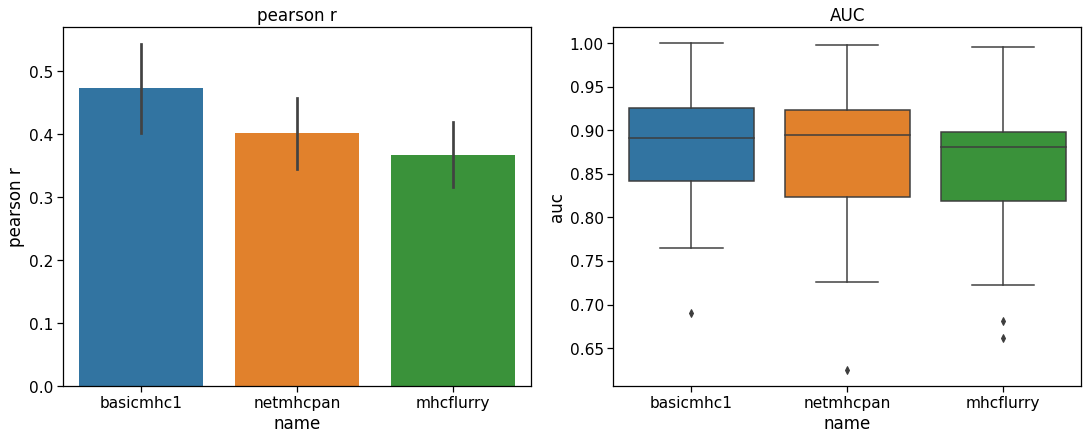

In [4]:
c = pd.read_csv('benchmarks.csv')
a=pd.pivot_table(c,index=['allele','size'],columns='name',values='auc')
r=pd.pivot_table(c,index=['allele','size'],columns='name',values='pearson r')
print (len(a))
def highlight_max(s):
    is_max = s == s.max()
    return ['background-color: yellow' if v else '' for v in is_max]

fig = plt.figure(constrained_layout=True,figsize=(15,6))
gs = fig.add_gridspec(1, 2, hspace=1)
ax = fig.add_subplot(gs[0])
#x.plot(x='basicmhc1',y='netmhcpan',kind='scatter',s=50,c='orange',ax=ax)
#x.plot(x='basicmhc1',y='mhcflurry',kind='scatter',s=50,c='green',ax=ax)
#ax.plot((0,1), (0,1), ls="--", lw=2, c=".2")
#ax.set_xlim(.76,.94);ax.set_ylim(.76,.94)
sns.barplot(data=c,y='pearson r',x='name',ax=ax)
ax.set_title('pearson r')

ax = fig.add_subplot(gs[1])
sns.boxplot(data=c,y='auc',x='name',ax=ax)
#ax = fig.add_subplot(gs[2:])
#g=sns.barplot(data=c,y='score',x='allele',hue='name', ax=ax)
#plt.legend(bbox_to_anchor=(1.1, 1.05),fontsize=16)
#plt.setp(ax.get_xticklabels(), rotation=90)
#plt.tight_layout()
ax.set_title('AUC')
plt.savefig('basicmhc1_benchmarks.jpg', dpi=150)
